# State of the Union

The State of the Union (SOTU) address is an address by the president of the United States to a joint session of Congress. This is a way for the president to comment on the well, state of the union. Legislative agendas and policy priorities are outlined. They tend to be fairly optimistic about the near term prospects for the country. 

These addresses give a good indication of what things are important to the American people (or at least the America president) during different time periods. I was curious if there were recurring themes that were present and if we could correlate topics found in these addresses to important world events. 

I've taken all of the SOTUs from [The American Presidency Project](http://www.presidency.ucsb.edu/sou.php) and have used notes by Gerhard Peters. He points out that some of these are not technically State of the Union addresses, but for our purposes I'll be treating them as such. There are several that were both radio addresses and written statements to Congress. I've taken only the written component of those. There are also several that were split over several days and over several documents (see Taft 1911-1912 and Nixon 1973). I've collected them each of those into a single document indexed by the first document that was delivered to Congress. That makes the analysis simpler down the road. 

We'll start off with some basis statistics and then we'll try to identify the topics in these texts. 

In [25]:
# Load some useful things
import re
from datetime import datetime, date, timedelta
from os import listdir
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import metrics

I've copied all the SOTUs from The American Presidency Project. It was slow and tedious, so I worked on it while watching silly things on Netflix. I'd like to learn how to crawl webpages and pull down data, so maybe that will be another project in the future. 

The first thing to do for our analyses is grab the SOTUs and save them as strings. We also want to save some information about the speech as well. The name of the president and the year that the SOTU was delivered are available in the name of the text file.

In [26]:
corpus, president, date_list, delivery_list = [], [], [], []
delivery_type = ['spoken','written']

# Load data for all SOTU addresses
for delivery in delivery_type:
    directory = 'sotu-texts/%s/' % delivery
    for f_name in listdir(directory):
        corpus.append(open(directory+f_name, 'r', encoding='utf8')
                      .read().replace('\n','').lower())
        president.append(' '.join(re.split('/|-',f_name)[0:2]))
        date_info = re.split('/|-|\.',f_name)[2:5]
        date_list.append(date(int(date_info[2]),
                         datetime.strptime(date_info[0], '%b').month,
                         int(date_info[1])))
        delivery_list.append(delivery)
    
# Save everything in a dataframe
sotu_df = pd.DataFrame({'sotu':      corpus,
                        'president': president,
                        'date':      date_list,
                        'delivery':  delivery_list
                       })
sotu_df = sotu_df.sort_values(by='date').reset_index(drop=True)
sotu_df.head()

,date,delivery,president,sotu
0,1790-01-08,spoken,george washington,fellow-citizens of the senate and house of rep...
1,1790-12-08,spoken,george washington,fellow-citizens of the senate and house of rep...
2,1791-10-25,spoken,george washington,fellow-citizens of the senate and house of rep...
3,1792-11-06,spoken,george washington,fellow-citizens of the senate and house of rep...
4,1793-12-03,spoken,george washington,fellow-citizens of the senate and house of rep...


First we might be curious about the length of these addresses. 

There is data available on [how many minutes](http://www.presidency.ucsb.edu/sou_minutes.php) each spoken SOTU was , but it's not available for all of them and obviously not for the written ones. We'll just stick with number of words then. 

We'll want to get rid of the contractions in these SOTUs as this will make our lives easier later on. We'll define a dictionary of English contractions with some help from [StackOverflow](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python). I used a dictionary from user [arturomp](https://stackoverflow.com/users/583834/arturomp) to save myself some time typing. 

In [27]:
# import a dictionary of English contractions from another file
from contractions import *
contraction_dict = english_contractions()

# replace the contractions with their expanded form
for contraction, expansion in contraction_dict.items():
    sotu_df['sotu'] = sotu_df['sotu'].str.replace(contraction.lower(),expansion.lower())
    
# check that we got all of them
for contraction, expansion in contraction_dict.items():
    if True in list(sotu_df['sotu'].str.contains(contraction.lower())):
        print("Warning: found contraction")

We can use a scikit-learn vectorizer to cleanly determine how many words are in each speech. We could also just split the text ourselves on whitespace, but this feels like the more data sciencey approach. Plus we'll be using this tool more down below. 

In [28]:
# Determine the number of words in each SOTU
vectorizer = TfidfVectorizer()
analyze = vectorizer.build_analyzer()
sotu_df['sotu_length'] = [len(analyze(text)) for text in sotu_df['sotu']]

We might want to look at how the length of these addresses have changed over time. We'll make a scatter plot and separate the spoken and written speeches since they're likely to be qualitatively different.

Summary for spoken SOTUs
------------------------------
Shortest SOTU :  1057 words by george washington on 1790-01-08
Longest  SOTU :  9569 words by dwight eisenhower on 1953-02-02

Summary for written SOTUs
------------------------------
Shortest SOTU :  1783 words by james madison on 1809-11-29
Longest  SOTU : 32997 words by jimmy carter on 1981-01-16



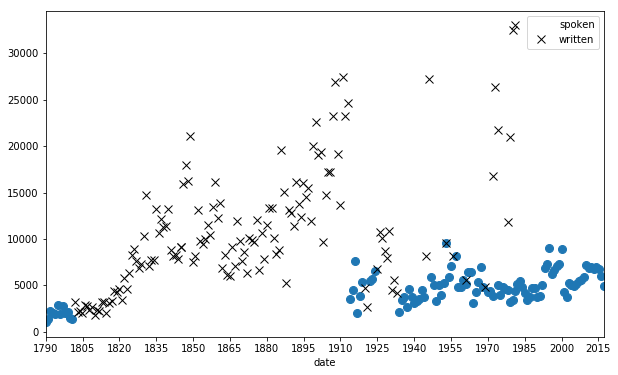

In [29]:
# Separate the spoken and written SOTUs
spoken_df  = sotu_df[sotu_df['delivery'] == 'spoken']
written_df = sotu_df[sotu_df['delivery'] == 'written']

# Make a scatter plot
ax = spoken_df.plot(x='date', y='sotu_length', label='spoken', style='o', ms=8)
written_df.plot(x='date', y='sotu_length', label='written', style='kx', ms=8, ax=ax)
ax.xaxis.set_ticks(np.arange('1790', '2017', 15, dtype='datetime64[Y]'))

# Print out the min/max length SOTUs
def print_min_max(df,delivery):
    '''Print out the min and maximum length SOTUs'''
    
    min_id, max_id = df['sotu_length'].idxmin(), df['sotu_length'].idxmax()
    print('Summary for %s SOTUs' % delivery)
    print('-'*30)
    print("Shortest SOTU : %5d words by %s on %s" % 
          (df['sotu_length'].loc[min_id], df['president'].loc[min_id], 
           str(df['date'].loc[min_id])))
    print("Longest  SOTU : %5d words by %s on %s\n" % 
          (df['sotu_length'].loc[max_id], df['president'].loc[max_id], 
           str(df['date'].loc[max_id])))

print_min_max(spoken_df,'spoken')
print_min_max(written_df,'written')

This is interesting. The written SOTUs are much longer than the spoken ones, so splitting up the SOTUs by delivery looks like it was a good idea. Now let's plot the distribution of the speech lengths to get an idea of how long they typically are. 

A split violin plot will be nice way to show how these distributions compare to one another. Since seaborn needs a common access to do this kind of plot, I've added another column for 'y' that is just blank. I've added this to a separation dataframe since it's not necessary otherwise. 

Summary for spoken SOTUs
------------------------------
count     100.000000
mean     4760.400000
std      1782.670899
min      1057.000000
25%      3648.000000
50%      4797.500000
75%      5897.500000
max      9569.000000
Name: sotu_length, dtype: float64

Summary for written SOTUs
------------------------------
count      137.000000
mean     10882.846715
std       6545.971378
min       1783.000000
25%       6689.000000
50%       9626.000000
75%      13610.000000
max      32997.000000
Name: sotu_length, dtype: float64



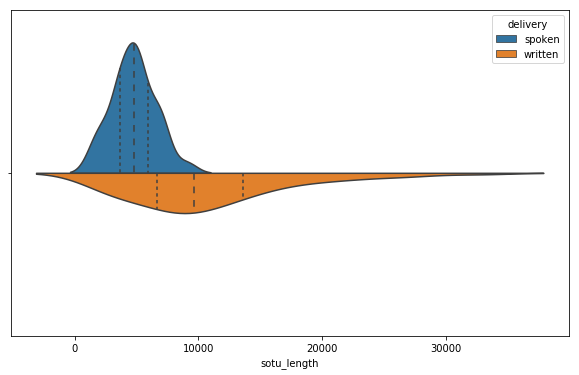

In [30]:
# make a new dataframe for plotting
violin_df = sotu_df.copy()
violin_df['y'] = ''

# make the violin plot
ax = sns.violinplot(y='y', x="sotu_length", hue="delivery",
                    data=violin_df, split=True, inner="quart")
ax.set_yticklabels('');
ax.set_ylabel('');

# Print out summary statistics for SOTUs
def print_stats(df,delivery):
    '''Print out summary statistics for SOTUs'''
    
    print('Summary for %s SOTUs' % delivery)
    print('-'*30)
    print(df['sotu_length'].describe())
    print()

print_stats(spoken_df,'spoken')
print_stats(written_df,'written')

Wow! The spoken SOTUs look pretty normally distributed and the written ones look very skewed. 

Let's print out some summary statistics to get a better understanding of these distributions.

In [31]:
def print_dist_summary(df,delivery):
    '''Print summary of SOTU length distributions'''
    
    print('Summary for %s SOTUs' % delivery)
    print('-'*30)
    print('Average Length : %6.2f words' % df['sotu_length'].mean())
    print('Skew           : %4.2f' % df['sotu_length'].skew())
    print('Kurtosis       : %4.2f\n' % df['sotu_length'].kurtosis())

print_dist_summary(spoken_df,'spoken')
print_dist_summary(written_df,'written')

Summary for spoken SOTUs
------------------------------
Average Length : 4760.40 words
Skew           : 0.21
Kurtosis       : -0.09

Summary for written SOTUs
------------------------------
Average Length : 10882.85 words
Skew           : 1.07
Kurtosis       : 1.17



I think we're ready to get into the real machine learning part of this investigation. 

# Text Content Analysis

Now let's get to identifying topics common in these texts. This will give us a way to understand commonalities among them and what things were important to the American people (or at least the American president) during these eras.

The TfidfVectorizer vectorizer will be helpful as it gives us a way to limit the importance of extremely common words like 'the' and 'a' that provide us no information about the documents. This module will scale words by their inverse document frequency, so those common words will be weighted less when we breakdown the documents into their different words. 

I've borrowed some code and ideas from Aneesha Bakharia's blog post on [Topic Modeling with Skikit Learn](https://medium.com/towards-data-science/improving-the-interpretation-of-topic-models-87fd2ee3847d) and his [follow up piece](https://medium.com/towards-data-science/improving-the-interpretation-of-topic-models-87fd2ee3847d). I believe he worked closely off of this [sklearn example](http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py), but he added some nice ways to analyze the results from these models in more detail. 

In [32]:
def display_topics(model, W, feature_names, df, 
                   n_top_words, n_top_documents):
    ''' Print out topics discovered by a model and which documents contain those topics '''
    
    for topic_idx, topic in enumerate(model.components_):
        print('Topic #%d: %s' % (topic_idx, ' '.join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])))

        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:n_top_documents]
        for doc_index in top_doc_indices:
            print('%20s on %s' % (df['president'][doc_index], df['date'][doc_index]))
        print('')

# define the number of samples, features, topics, and how many 
# words/documents to display later on
n_samples       = 2000
n_features      = 1000
n_topics        = 15
n_top_words     = 10
n_top_documents = 5

First we'll define our vectorizer. We'll ignore words that appear in more than 95% of the documents and words that appear in less than 2 documents.

In [33]:
# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(sotu_df['sotu'])

We'll be using a Non-negative Matrix Factorization (NMF) to extract the topics from these texts. It breaks down a matrix of documents into linear combinations of topics. The [wikipedia page](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) gives a good introduction to the topic. I'm using the Frobenius norm as my error metric and have included a little bit of L1 regularization. 

There are other metrics we could use and we could use another approach like [Latent Dirichlet Allocation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html), but when I tried these there was no appreciable difference to my first approach. 

For our purposes, it's only important to know that I'm extracting the main topics that are common to the different SOTUs. Things that don't show up often won't be identified. 

In [34]:
# Fit the NMF model using the Frobenius norm
nmf = NMF(n_components=n_topics, random_state=1, 
          alpha=.1, l1_ratio=.5, solver='mu',
          beta_loss='frobenius').fit(tfidf)

print("\nTopics in NMF model (Frobenius norm):\n")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
display_topics(nmf, nmf.transform(tfidf), tfidf_feature_names, 
               sotu_df, n_top_words, n_top_documents)


Topics in NMF model (Frobenius norm):

Topic #0: general present subject 000 citizens shall law department act attention
    millard fillmore on 1851-12-02
      andrew jackson on 1829-12-08
      james buchanan on 1858-12-06
      andrew jackson on 1832-12-04
    millard fillmore on 1852-12-06

Topic #1: america tonight americans help american world years let budget make
     william clinton on 1998-01-27
     william clinton on 1997-02-04
     william clinton on 2000-01-27
     william clinton on 1999-01-19
        georgeW bush on 2004-01-20

Topic #2: program federal economic legislation administration programs development farm housing problems
   dwight eisenhower on 1956-01-05
   dwight eisenhower on 1957-01-10
        jimmy carter on 1978-01-19
        jimmy carter on 1980-01-21
        jimmy carter on 1979-01-25

Topic #3: world economic free strength defense today shall military freedom production
   dwight eisenhower on 1959-01-09
   dwight eisenhower on 1958-01-09
  franklin

Ok, now we have some interesting stuff to talk about! Let's breakdown these topics and see what these SOTUs have in common. 

Interestingly, many of these topics are attributed to SOTUs from common eras. This is likely because the problems of an era are addressed by the presidents of those eras. The really interesting results are when well-separated SOTUs are grouped together. We'll mostly focus on those, but will mention some other interesting points in history. 

 - Topic #5: This one looks to be about the Soviet Union as an aggressor and economic power that challenged the US. Truman and Eisenhower were concerned about this during the height of McCarthyism. Carter and Reagan spoke about the Soviet Union during the Soviet-Afghan War.
 
 - Topic #8: Madison's and Roosevelt's presidencies are separated by 100+ years, so it's a little surprising to see them grouped together. In his addresses Madison is writing about the British during the War of 1812. Roosevelt is speaking about Britain as an ally at the start of the US' involvement in WWII. They're both talking about war and Britain, but as a foe and as an ally. 
 
 - Topic #9: Tyler and Polk were understandable concerned about relations with Texas and Mexico. Under Tyler's presidency the Republic of Texas was annexed in 1845. This then sparked the Mexican-American War which lasted through much of Polk's presidency. 
 
 - Topic #12: President Obama had to deal with the Great Recession, so jobs and the ability to work were front and center in his addresses. 
 
 - Topic #13: The energy crises of the 70s were great concerns for America. The Soviet Union was a large oil producing state, so they were also featured in the addresses of Ford and Carter. 

# Wrap-up

We cleaned up the SOTU data set I collected and learned things. The length of written SOTUs is not normally distributed and is skewed toward longer speaches. There are many important topics that appear across several SOTU addresses, such as the Soviet Union, the energy crises of the 70s, and the concerns about war. 

There's still a lot we can tease out from this data set, but I'll leave things here for now. We can always revisit in the future. 